In [ ]:
!pip install -q transformers datasets tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config, set_seed
from datasets import load_dataset

In [ ]:
magic_seed = 22
set_seed(magic_seed)

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего.

In [ ]:
emotion_dataset = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

0

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer(emotion_dataset["train"]["text"][0], return_tensors="pt") #encode_plus is deprecated method for __call__

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0],
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
n_labels = len(np.unique(emotion_dataset['train']["label"]))

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = device

        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}

    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]

        tokenizer_output = tokenizer.encode_plus(text, max_length=self.max_length,
                                                 padding='max_length', return_tensors="pt")#.to(self.device)
        target = self.label2num[label] #torch.tensor(self.label2num[label], dtype=int).to(self.device)
     #   print('label:', label)
     #   print('target:', target)
        return {
            "input_ids": tokenizer_output['input_ids'][0],
            "attention_mask": tokenizer_output['attention_mask'][0],
            "labels": target
        }

    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset('train')
valid_dataset = TweetDataset('validation')
test_dataset = TweetDataset('test')

In [ ]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    shuffle=False,
    batch_size=batch_size,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=batch_size,
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.pad_token_id,
    num_labels=n_labels,
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

In [ ]:
len(train_dataset)

16000

Подготовь оптимайзер и критерий:

In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from transformers import get_cosine_schedule_with_warmup

num_epochs = 10
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(num_training_steps * 0.1)

optimizer = AdamW(model_0.parameters(), lr=lr)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
#criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
#scheduler = StepLR(optimizer, step_size=2, gamma=0.35)

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
ex_train_batch = next(iter(train_loader))
ex_valid_batch = next(iter(valid_loader))

In [ ]:
# Проверим на одном батче, что модель действительно обучается
from tqdm.notebook import tqdm
for e in tqdm(range(num_epochs* 10)):
    model_0.train()
    train_loss = 0
    train_acc = 0
    target = ex_train_batch['labels'].numpy().flatten().tolist()
       # input_ids = batch['input_ids'].squeeze(1).to(device)
      #  print('input_ids:', input_ids)
       # print('input_ids.shape:', input_ids.shape)
       # mask = batch['attention_mask'].squeeze(1).to(device)
       # print('mask.shape:', mask.shape)
       # labels = batch['labels']
       # print('labels:', labels)
       # print('labels.shape:', labels.shape)
    batch = {k: v.type(torch.long).to(device) for k, v in ex_train_batch.items()}
    optimizer.zero_grad()
    model_output = model_0(**batch)
        #model_output = model_0(input_ids=input_ids, attention_mask=mask)
       # target = batch['labels']
    loss, logits = model_output[:2]
       # loss = criterion(logits, target)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model_0.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
      #  print('train batch_loss =', loss.item())
    train_loss += loss.item()
    logits = logits.detach().cpu().numpy()
    prediction = logits.argmax(axis=-1).flatten().tolist()
    train_acc += sum([t == p for t, p in zip(target, prediction)])


    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
            target = ex_valid_batch['labels'].numpy().flatten().tolist()
            batch = {k: v.type(torch.long).to(device) for k, v in ex_valid_batch.items()}
          # input_ids = batch['input_ids'].squeeze(1)
          #  mask = batch['mask'].squeeze(1)
            model_output = model_0(**batch)
           # print('model_output.keys:', model_output.keys())
          #  target = batch['target']
            loss, logits = model_output[:2]
            logits = logits.detach().cpu().numpy()
            prediction = logits.argmax(axis=-1).flatten().tolist()
            valid_acc += sum([t == p for t, p in zip(target, prediction)])
          #  batch_loss = criterion(logits, target)
         #   print('valid batch_loss =', loss.item())
            valid_loss += loss.item()
         #   print('logits:', logits)
    print(f"Train Loss: {train_loss},",
          f"Train Acc: {train_acc},",
          f"Valid Loss: {valid_loss},",
          f"Valid Acc: {valid_acc}")

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 2.0052506923675537, Train Acc: 10, Valid Loss: 1.9248275756835938, Valid Acc: 9
Train Loss: 1.984398603439331, Train Acc: 12, Valid Loss: 1.919736623764038, Valid Acc: 9
Train Loss: 1.906768560409546, Train Acc: 9, Valid Loss: 1.9097079038619995, Valid Acc: 9
Train Loss: 1.990654706954956, Train Acc: 7, Valid Loss: 1.8949401378631592, Valid Acc: 9
Train Loss: 1.9441202878952026, Train Acc: 8, Valid Loss: 1.8755871057510376, Valid Acc: 10
Train Loss: 1.921149492263794, Train Acc: 12, Valid Loss: 1.851952075958252, Valid Acc: 10
Train Loss: 1.8660285472869873, Train Acc: 13, Valid Loss: 1.8245739936828613, Valid Acc: 10
Train Loss: 1.877312183380127, Train Acc: 12, Valid Loss: 1.7938616275787354, Valid Acc: 10
Train Loss: 1.8591678142547607, Train Acc: 9, Valid Loss: 1.759774923324585, Valid Acc: 11
Train Loss: 1.8292288780212402, Train Acc: 11, Valid Loss: 1.723262071609497, Valid Acc: 14
Train Loss: 1.7887929677963257, Train Acc: 12, Valid Loss: 1.6846545934677124, Valid Ac

In [20]:
# Train loop
model = GPT2ForSequenceClassification(config=config).to(device)
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
for e in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch in tqdm(train_loader):
        target = batch['labels'].numpy().flatten().tolist()
       # input_ids = batch['input_ids'].squeeze(1).to(device)
      #  print('input_ids:', input_ids)
       # print('input_ids.shape:', input_ids.shape)
       # mask = batch['attention_mask'].squeeze(1).to(device)
       # print('mask.shape:', mask.shape)
       # labels = batch['labels']
       # print('labels:', labels)
       # print('labels.shape:', labels.shape)
        batch = {k: v.type(torch.long).to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        model_output = model(**batch)
        #model_output = model_0(input_ids=input_ids, attention_mask=mask)
       # target = batch['labels']
        loss, logits = model_output[:2]
       # loss = criterion(logits, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
      #  print('train batch_loss =', loss.item())
        train_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        prediction = logits.argmax(axis=-1).flatten().tolist()
        train_acc += sum([t == p for t, p in zip(target, prediction)])


    valid_loss = 0
    valid_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            target = batch['labels'].numpy().flatten().tolist()
            batch = {k: v.type(torch.long).to(device) for k, v in batch.items()}
          # input_ids = batch['input_ids'].squeeze(1)
          #  mask = batch['mask'].squeeze(1)
            model_output = model(**batch)

          #  target = batch['target']
            loss, logits = model_output[:2]
            logits = logits.detach().cpu().numpy()
            prediction = logits.argmax(axis=-1).flatten().tolist()
            valid_acc += sum([t == p for t, p in zip(target, prediction)])
          #  batch_loss = criterion(logits, target)
         #   print('valid batch_loss =', loss.item())
            valid_loss += loss.item()
         #   print('logits:', logits)
    print(f"Train Loss: {train_loss / len(train_loader)},",
          f"Train Acc: {train_acc / len(train_loader)},",
          f"Valid Loss: {valid_loss / len(valid_loader)},",
          f"Valid Acc: {valid_acc / len(valid_loader)}")

# Testing

#test_acc = 0
#model_0.eval()
#with torch.no_grad():
#    for batch in test_loader:
#        ...
#print(f"Test Acc: {test_acc / len(test_loader)}")


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.6142852926254272, Train Acc: 21.324, Valid Loss: 1.5249893739819527, Valid Acc: 23.90625


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.3953917026519775, Train Acc: 29.092, Valid Loss: 1.2309541627764702, Valid Acc: 33.40625


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.0422770364284515, Train Acc: 39.168, Valid Loss: 0.9496060088276863, Valid Acc: 41.40625


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.7571418088674545, Train Acc: 46.36, Valid Loss: 0.7745583839714527, Valid Acc: 45.21875


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.573719381570816, Train Acc: 50.536, Valid Loss: 0.6774059049785137, Valid Acc: 47.53125


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.45308528119325636, Train Acc: 53.588, Valid Loss: 0.6424946496263146, Valid Acc: 48.59375


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.3554663632512093, Train Acc: 55.748, Valid Loss: 0.5957312230020761, Valid Acc: 50.28125


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.30394178894162177, Train Acc: 56.888, Valid Loss: 0.5944949230179191, Valid Acc: 50.5


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.2690623794496059, Train Acc: 57.9, Valid Loss: 0.5902634407393634, Valid Acc: 50.6875


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.25951498582959176, Train Acc: 58.224, Valid Loss: 0.583447496406734, Valid Acc: 50.875


In [21]:
# Testing
test_acc = 0
model.eval()
with torch.no_grad():
    for batch in test_loader:
        target = batch['labels'].numpy().flatten().tolist()
        batch = {k: v.type(torch.long).to(device) for k, v in batch.items()}
        model_output = model(**batch)
          #  target = batch['target']
        loss, logits = model_output[:2]
        logits = logits.detach().cpu().numpy()
        prediction = logits.argmax(axis=-1).flatten().tolist()
        test_acc += sum([t == p for t, p in zip(target, prediction)])
          #  batch_loss = criterion(logits, target)
print(f"Test Acc: {test_acc / len(test_loader)}")

Test Acc: 49.15625


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
 #   print('attn_tensors:', attn_tensors)
 #   print('attn_tensors.shape:', attn_tensors.shape)
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
 #   print('attn:', attn)
 #   print('attn.shape:', np.array(attn).shape)
    return np.array(attn)

In [23]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [24]:
text = emotion_dataset['test']['text'][9] # Выбери текст из датасета
print('text:', text)
tokens = tokenizer.tokenize(text)

text: i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week and im about as fit as a walrus on vacation for the summer


<ipython-input-23-0d31a6ec8e7d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
<ipython-input-23-0d31a6ec8e7d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+seq, fontsize=16)


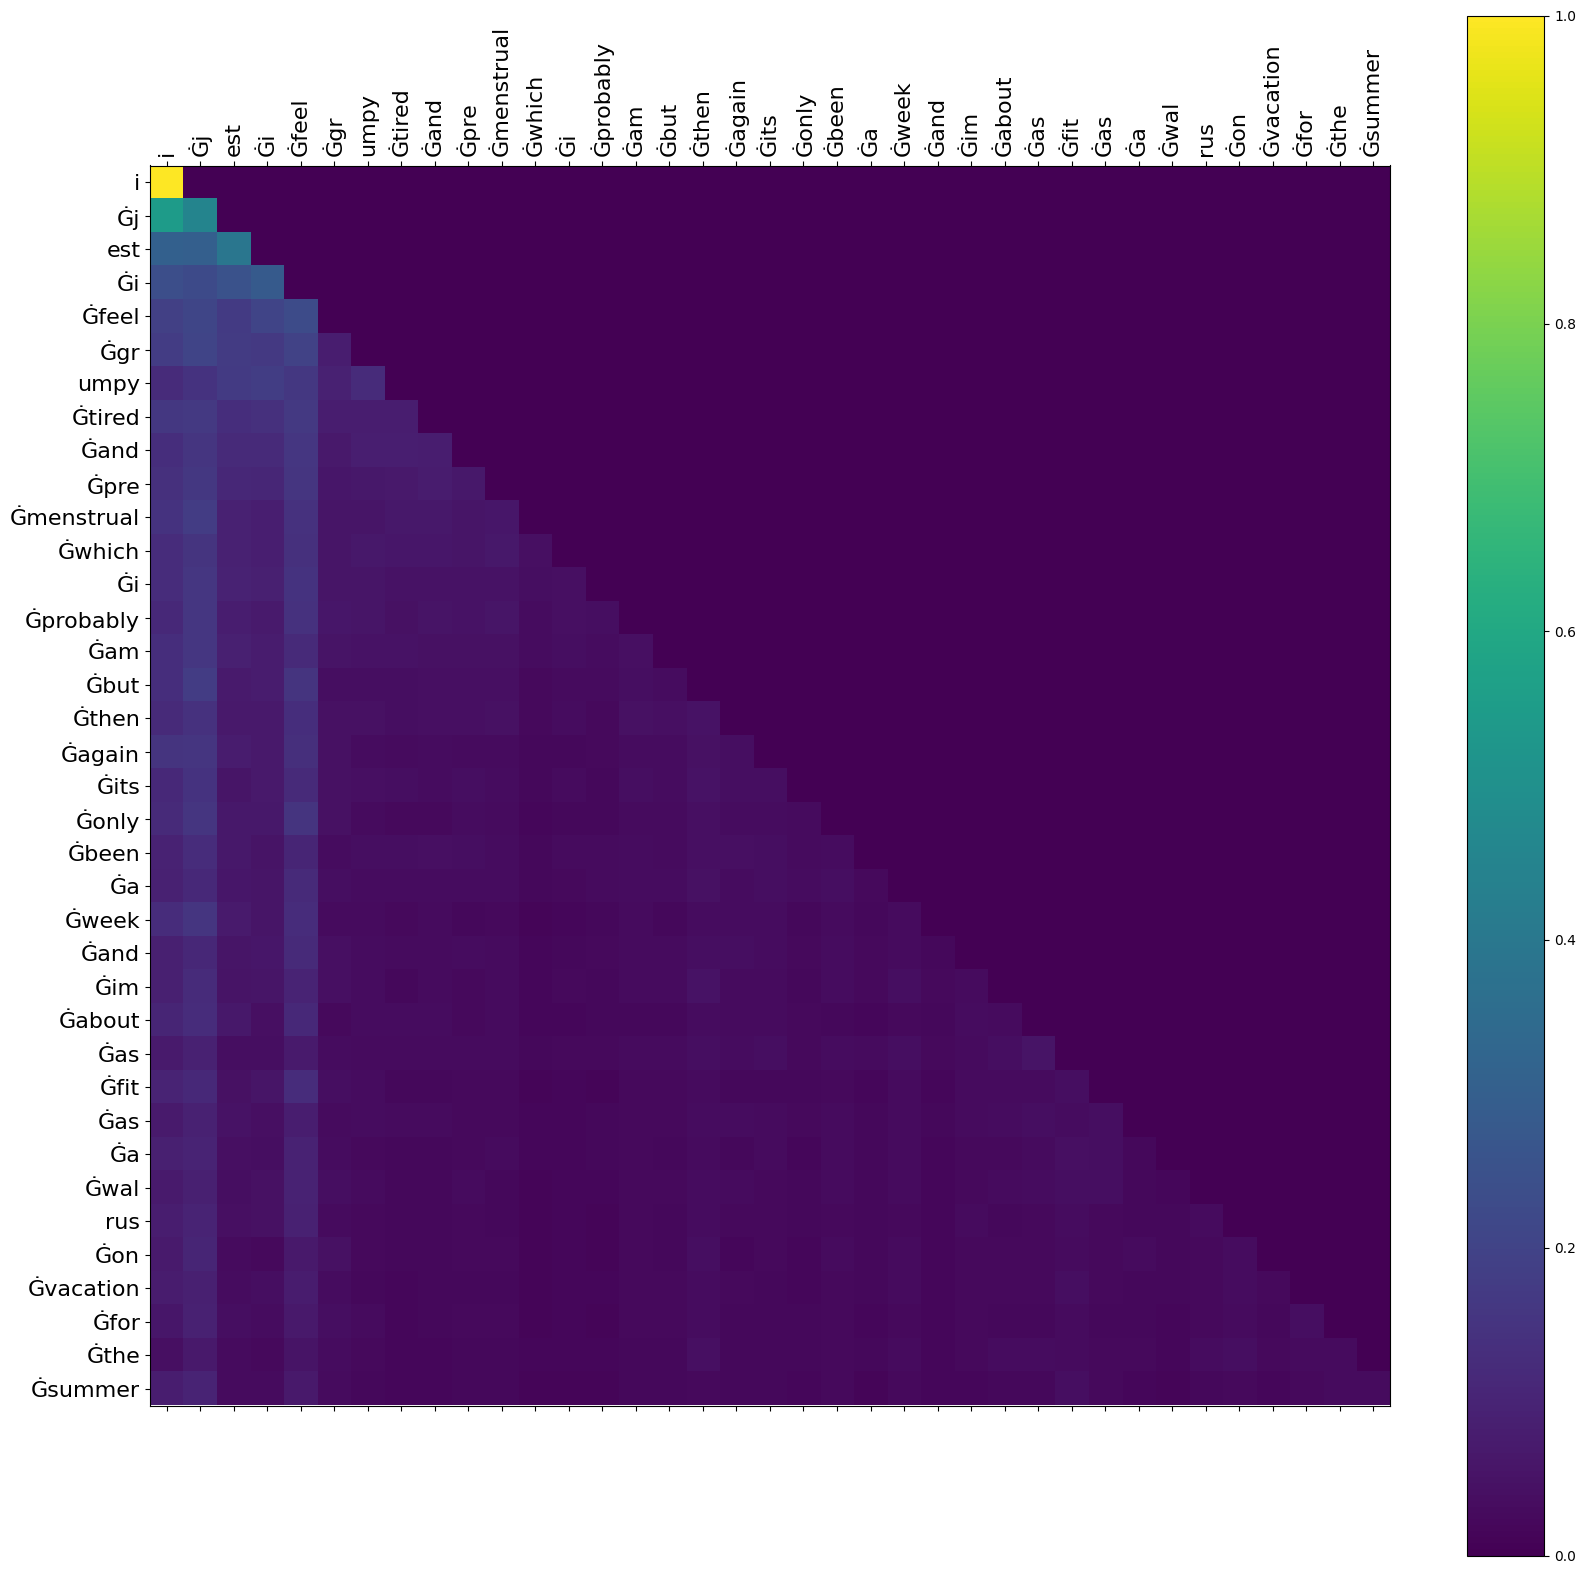

In [25]:
attns = get_attention_matrixes(model, tokenizer, text)
#print('attns:', attns)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [26]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2",
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=n_labels,
).to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 10
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = num_training_steps * 0.1

optimizer = AdamW(model_1.parameters(), lr=lr)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
from tqdm.notebook import tqdm


for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    train_acc = 0
    for batch in tqdm(train_loader):
        target = batch['labels'].numpy().flatten().tolist()
       # input_ids = batch['input_ids'].squeeze(1).to(device)
      #  print('input_ids:', input_ids)
       # print('input_ids.shape:', input_ids.shape)
       # mask = batch['attention_mask'].squeeze(1).to(device)
       # print('mask.shape:', mask.shape)
       # labels = batch['labels']
       # print('labels:', labels)
       # print('labels.shape:', labels.shape)
        batch = {k: v.type(torch.long).to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        model_output = model_1(**batch)
        #model_output = model_1(input_ids=input_ids, attention_mask=mask)
       # target = batch['labels']
        loss, logits = model_output[:2]
       # loss = criterion(logits, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_1.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
      #  print('train batch_loss =', loss.item())
        train_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        prediction = logits.argmax(axis=-1).flatten().tolist()
        train_acc += sum([t == p for t, p in zip(target, prediction)])


    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            target = batch['labels'].numpy().flatten().tolist()
            batch = {k: v.type(torch.long).to(device) for k, v in batch.items()}
          # input_ids = batch['input_ids'].squeeze(1)
          #  mask = batch['mask'].squeeze(1)
            model_output = model_1(**batch)

          #  target = batch['target']
            loss, logits = model_output[:2]
            logits = logits.detach().cpu().numpy()
            prediction = logits.argmax(axis=-1).flatten().tolist()
            valid_acc += sum([t == p for t, p in zip(target, prediction)])
          #  batch_loss = criterion(logits, target)
         #   print('valid batch_loss =', loss.item())
            valid_loss += loss.item()
         #   print('logits:', logits)
    print(f"Train Loss: {train_loss / len(train_loader)},",
          f"Train Acc: {train_acc / len(train_loader)},",
          f"Valid Loss: {valid_loss / len(valid_loader)},",
          f"Valid Acc: {valid_acc / len(valid_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.9205912594497204, Train Acc: 44.78, Valid Loss: 0.23656732286326587, Valid Acc: 57.0625


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.18613126128166915, Train Acc: 59.208, Valid Loss: 0.15469708596356213, Valid Acc: 58.0625


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.12450405991822482, Train Acc: 60.268, Valid Loss: 0.14932139043230563, Valid Acc: 58.90625


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.10018332911655307, Train Acc: 60.628, Valid Loss: 0.14186183735728264, Valid Acc: 58.84375


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.08229471370577812, Train Acc: 61.364, Valid Loss: 0.1346562944818288, Valid Acc: 58.875


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.06053700125927571, Train Acc: 62.104, Valid Loss: 0.1638484784634784, Valid Acc: 58.5625


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.04060612118593417, Train Acc: 62.92, Valid Loss: 0.1692222907440737, Valid Acc: 58.75


  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        target = batch['labels'].numpy().flatten().tolist()
        batch = {k: v.type(torch.long).to(device) for k, v in batch.items()}
        model_output = model_1(**batch)
          #  target = batch['target']
        loss, logits = model_output[:2]
        logits = logits.detach().cpu().numpy()
        prediction = logits.argmax(axis=-1).flatten().tolist()
        test_acc += sum([t == p for t, p in zip(target, prediction)])
          #  batch_loss = criterion(logits, target)
print(f"Test Acc: {test_acc / len(test_loader)}")

Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = emotion_dataset['test']['text'][9] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

In [ ]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше?
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

Подход с файн-тьюнингом модели показал лучший результат.
Последняя голова больше всего обращала внимание на слово "feel"